### Init: importing libraries and creating datasets

In [1]:
# Imports
import tensorflow as tf # tensorflow 2.10
import numpy as np # numpy 1.21.5
import matplotlib.pyplot as plt
from data_generation import get_sample
from evals_WGANGP import evals_WGANGP
from evecs_WGANGP import evecs_WGANGP
import datetime

# General variable
BATCH_SIZE = 16
NB_BATCH = 10
TRAINING_SET_SIZE = BATCH_SIZE*NB_BATCH
NB_STEPS = 5

In [2]:
# Generating dataset
sample_dataset = [get_sample() for _ in range(TRAINING_SET_SIZE)]
evecs_dataset = tf.convert_to_tensor([s[0] for s in sample_dataset])
evals_dataset = tf.convert_to_tensor([s[1] for s in sample_dataset])

2022-11-15 14:55:41.315901: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-15 14:55:41.316406: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [ ]:
# Print evals critic model:
evals_wgangp = evals_WGANGP()
evals_wgangp.compile()

model_critic_evals = evals_wgangp.critic
model_generator_evals = evals_wgangp.generator

evecs_wgangp = evecs_WGANGP()
evecs_wgangp.compile()

model_critic_evecs = evecs_wgangp.critic
model_generator_evecs = evecs_wgangp.generator

models = [  (model_critic_evals, "model_critic_evals"), 
            (model_generator_evals, "model_generator_evals"),
            (model_critic_evecs, "model_critic_evecs"),
            (model_generator_evecs,"model_generator_evecs")
        ]

for model, name in models:
    tf.keras.utils.plot_model(
        model,
        to_file=f"{name}.png",
        show_shapes=False,
        show_dtype=False,
        show_layer_names=True,
        rankdir="TB",
        expand_nested=False,
        dpi=96,
        layer_range=None,
        show_layer_activations=False,
    ) 

### Print example of eigenvalues

In [ ]:
from eigenmanipulation import normalize_evals
import random


random_index = random.randint(0, evals_dataset.shape[0]-1)
print(f"index={random_index}")
eval_ex = normalize_evals(evals_dataset[random_index])
eval_ex = np.sort(np.array(eval_ex[:, :, 0]).flatten())
eval_ex_dB = 10*np.log10(eval_ex)

fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title("Normalized value")
plt.plot(eval_ex)

plt.subplot(1,2,2)
plt.title("in dB")
plt.plot(eval_ex_dB)

fig.suptitle('Generated eigenvalues', fontsize=16)

In [ ]:
from eigenmanipulation import normalize_evecs
import random


random_index = random.randint(0, evecs_dataset.shape[0]-1)
print(f"index={random_index}")
evec_ex = normalize_evals(evecs_dataset[random_index])

evec_ex_real = evec_ex[:, :, 0] # get real part from sample
evec_ex_imag = evec_ex[:, :, 1] # get imaginary part from sample


fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title("Real part")
plt.imshow(evec_ex_real)

plt.subplot(1,2,2)
plt.title("Imaginary part")
plt.imshow(evec_ex_imag)

fig.suptitle('Eigenvectors from dataset', fontsize=16)

### Print example of eigenvectors

### Initiating and training WGAN-GP for eigenvectors

In [ ]:
# Generating eigenvectors

# Creating GAN
evecs_wgangp = evecs_WGANGP()

# Compiling GAN
evecs_wgangp.compile()

# Creating tensorboard callback
log_dir = "logs/evecs_wgangp_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Training GAN
evecs_wgangp.fit(
    evecs_dataset,
    batch_size=BATCH_SIZE,
    epochs=NB_BATCH,
    steps_per_epoch=NB_STEPS,
    callbacks=[tensorboard_callback]
)
# time for epoch=100, step=1, batch_size=16 -> approx 15min.

In [ ]:
# Creating and plotting fake sample
_, evecs = evecs_wgangp.generate_evecs(nb_trial=10)

evecs_real = evecs[0, :, :, 0] # get real part from sample
evecs_imag = evecs[0, :, :, 1] # get imaginary part from sample


fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title("Real part")
plt.imshow(evecs_real)

plt.subplot(1,2,2)
plt.title("Imaginary part")
plt.imshow(evecs_imag)

fig.suptitle('Eigenvectors', fontsize=16)


### Initiating and training WGAN-GP for eigenvalues

In [ ]:
# Generating eigenvalues

# Creating GAN
evals_wgangp = evals_WGANGP()

# Compiling GAN
evals_wgangp.compile()

# Creating tensorboard callback
log_dir = "logs/fit/evals_wgangp_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Training GAN
evals_wgangp.fit(
    evals_dataset,
    batch_size=BATCH_SIZE,
    epochs=NB_BATCH,
    steps_per_epoch=NB_STEPS,
    callbacks=[tensorboard_callback]
)



# time for epoch=100, step=5, batch_size=16 -> approx 18min.
# time for epoch=100, step=10, batch_size=16 -> approx 32min.
# time for epoch=100, step=20, batch_size=16 -> approx _min.

In [ ]:
# Creating and plotting fake sample
_, evals = evals_wgangp.generate_evals(nb_trial=10)

evals = np.sort(np.array(evals[0, :, :, 0]).flatten()) # convert sample from (1,8,8,1) to (64,)
evals_dB = 10*np.log10(evals)

fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title("Normalized value")
plt.plot(evals)

plt.subplot(1,2,2)
plt.title("in dB")
plt.plot(evals_dB)

fig.suptitle('Eigenvalues', fontsize=16)

In [ ]:
%tensorboard --logdir logs

### Performing Beamforming with generated samples

In [ ]:
from beamforming import beamform, get_csm

_, generated_evals = evals_wgangp.generate_evals(nb_trial=10)
_, generated_evecs = evecs_wgangp.generate_evecs(nb_trial=10)

# reshape data
evals_vec_numpy = np.sort(np.array(generated_evals[0, :, :, 0]).flatten())
evals_vec = tf.convert_to_tensor(evals_vec_numpy)
evecs_real = generated_evecs[0, :, :, 0] # get real part from sample
evecs_imag = generated_evecs[0, :, :, 1] # get imaginary part from sample

"""
print("-=-=-=-=-=-=-=-=-=-=-=-=-")
print(f"real_evecs_real.shape={evecs_real.shape}")
print(f"real_evecs_imag.shape={evecs_imag.shape}")
print(f"tmp_evals_vec.shape={evals_vec.shape}")
print("-=-=-=-=-=-=-=-=-=-=-=-=-")
"""

csm = get_csm(evecs_real, evecs_imag, evals_vec).numpy()

NUMFREQ = 1 # one freq with index bin = 13 ? -> is that accurate ?
NUMCHANNELS = 64

csm = np.reshape(csm, newshape=(NUMFREQ,NUMCHANNELS,NUMCHANNELS))

beamform(csm)

### Data augmentation 

In [3]:
from data_augmentation import get_augmentented_dataset

evecs_subdataset = evecs_dataset[:1,:,:,:]

augmented_sample_dataset = get_augmentented_dataset(
                            evals_dataset=evals_dataset,
                            batch_size=BATCH_SIZE,
                            nb_batch=NB_BATCH,
                            steps_per_epoch=NB_STEPS,
                            evecs_dataset=evecs_subdataset,
                            size_augmentation=10
                            )

augmented_evecs_dataset = tf.convert_to_tensor([s[0] for s in augmented_sample_dataset])
augmented_evals_dataset = tf.convert_to_tensor([s[1] for s in augmented_sample_dataset])

Epoch 1/10
5/5 [==============================] - 16s 2s/step - c_loss: 3.8063 - g_loss: 0.6490
Epoch 2/10
5/5 [==============================] - 10s 2s/step - c_loss: -3.3526 - g_loss: 3.9465
Epoch 3/10
5/5 [==============================] - 10s 2s/step - c_loss: -4.8732 - g_loss: 5.2366
Epoch 4/10
5/5 [==============================] - 10s 2s/step - c_loss: -4.9593 - g_loss: 5.5704
Epoch 5/10
5/5 [==============================] - 11s 2s/step - c_loss: -4.9109 - g_loss: 5.4360
Epoch 6/10
5/5 [==============================] - 11s 2s/step - c_loss: -5.1621 - g_loss: 5.5429
Epoch 7/10
5/5 [==============================] - 10s 2s/step - c_loss: -5.0711 - g_loss: 5.6582
Epoch 8/10
5/5 [==============================] - 11s 2s/step - c_loss: -4.9319 - g_loss: 5.4181
Epoch 9/10
5/5 [==============================] - 14s 3s/step - c_loss: -4.9488 - g_loss: 5.4717
Epoch 10/10
5/5 [==============================] - 13s 3s/step - c_loss: -5.1181 - g_loss: 5.6444
(64, 64, 2)
=========== 0 ====

In [8]:
print(augmented_evals_dataset.shape)
print(augmented_evecs_dataset.shape)

(10, 1, 8, 8, 1)
(10, 64, 64, 2)


(64,)


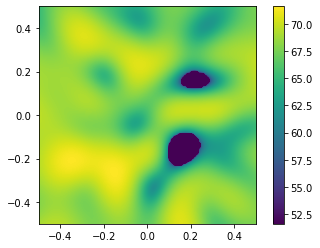

In [9]:
from beamforming import beamform, get_csm

NUMFREQ = 1
NUMCHANNELS = 64

augmented_evals = augmented_evals_dataset[0,:,:,:]
augmented_evecs = augmented_evecs_dataset[0,:,:,:]

evals_vec_numpy = np.sort(np.array(augmented_evals[0,:, :, 0]).flatten())
evals_vec = tf.convert_to_tensor(evals_vec_numpy) 

evecs_real = augmented_evecs[:,:,0]
evecs_imag = augmented_evecs[:,:,1]

csm = get_csm(evecs_real, evecs_imag, evals_vec).numpy()
csm = np.reshape(csm, newshape=(NUMFREQ,NUMCHANNELS,NUMCHANNELS))

beamform(csm)